# Develop a predictive maintenance model using LSTM-RNN to forecast equipment failures, enabling proactive maintenance and reducing downtime.
Note: Download any dataset  to satisfy the problem statement

In [4]:
# Data Analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning tools
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

# Machine Learning algos
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# Keras for RNN
from keras.models import load_model
from keras.callbacks import EarlyStopping 
from keras.models import Sequential
from keras.layers import Dense, Dropout, ConvLSTM2D, LSTM, Activation

In [5]:
# Load the data in kaggle
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# Save as dataframe
train_df = pd.read_csv('Train_Data_CSV.csv')
test_df = pd.read_csv('Test_Data_CSV.csv')

In [6]:
train_df.head()


,Data_No,Differential_pressure,Flow_rate,Time,Dust_feed,Dust
0,1,0.0,0.0,0.1,236.428943,"ISO 12103-1, A3 Medium Test Dust"
1,1,0.0,0.0,0.2,236.428943,"ISO 12103-1, A3 Medium Test Dust"
2,1,0.0,0.0,0.3,236.428943,"ISO 12103-1, A3 Medium Test Dust"
3,1,0.0,0.0,0.4,236.428943,"ISO 12103-1, A3 Medium Test Dust"
4,1,0.0,0.0,0.5,236.428943,"ISO 12103-1, A3 Medium Test Dust"


In [7]:
test_df.head()


,Data_No,Differential_pressure,Flow_rate,Time,Dust_feed,Dust,RUL
0,1,0.271267,52.281993,0.1,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.9
1,1,0.361690,54.986671,0.2,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.8
2,1,0.000000,55.424786,0.3,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.7
3,1,2.622251,55.524146,0.4,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.6
4,1,3.888165,55.852018,0.5,236.428943,"ISO 12103-1, A3 Medium Test Dust",58.5


In [8]:
train_df.describe()


,Data_No,Differential_pressure,Flow_rate,Time,Dust_feed
count,39420.000000,39420.000000,39420.000000,39420.000000,39420.000000
mean,25.167453,78.232050,66.095780,49.135490,132.247854
std,14.315149,107.342894,11.306582,39.088269,62.716754
min,1.000000,0.000000,0.000000,0.100000,59.107236
25%,12.000000,8.590133,58.458498,19.800000,79.246266
50%,24.000000,35.174340,59.040107,39.900000,118.214472
75%,38.000000,102.358200,81.136739,65.800000,158.492533
max,50.000000,607.910200,84.199355,179.400000,316.985065


In [9]:
train_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39420 entries, 0 to 39419
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Data_No                39420 non-null  int64  
 1   Differential_pressure  39420 non-null  float64
 2   Flow_rate              39420 non-null  float64
 3   Time                   39420 non-null  float64
 4   Dust_feed              39420 non-null  float64
 5   Dust                   39420 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 1.8+ MB


In [10]:
test_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39414 entries, 0 to 39413
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Data_No                39414 non-null  int64  
 1   Differential_pressure  39414 non-null  float64
 2   Flow_rate              39414 non-null  float64
 3   Time                   39414 non-null  float64
 4   Dust_feed              39414 non-null  float64
 5   Dust                   39414 non-null  object 
 6   RUL                    39414 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 2.1+ MB


Text(0.5, 1.0, 'Differential Pressure over Time')

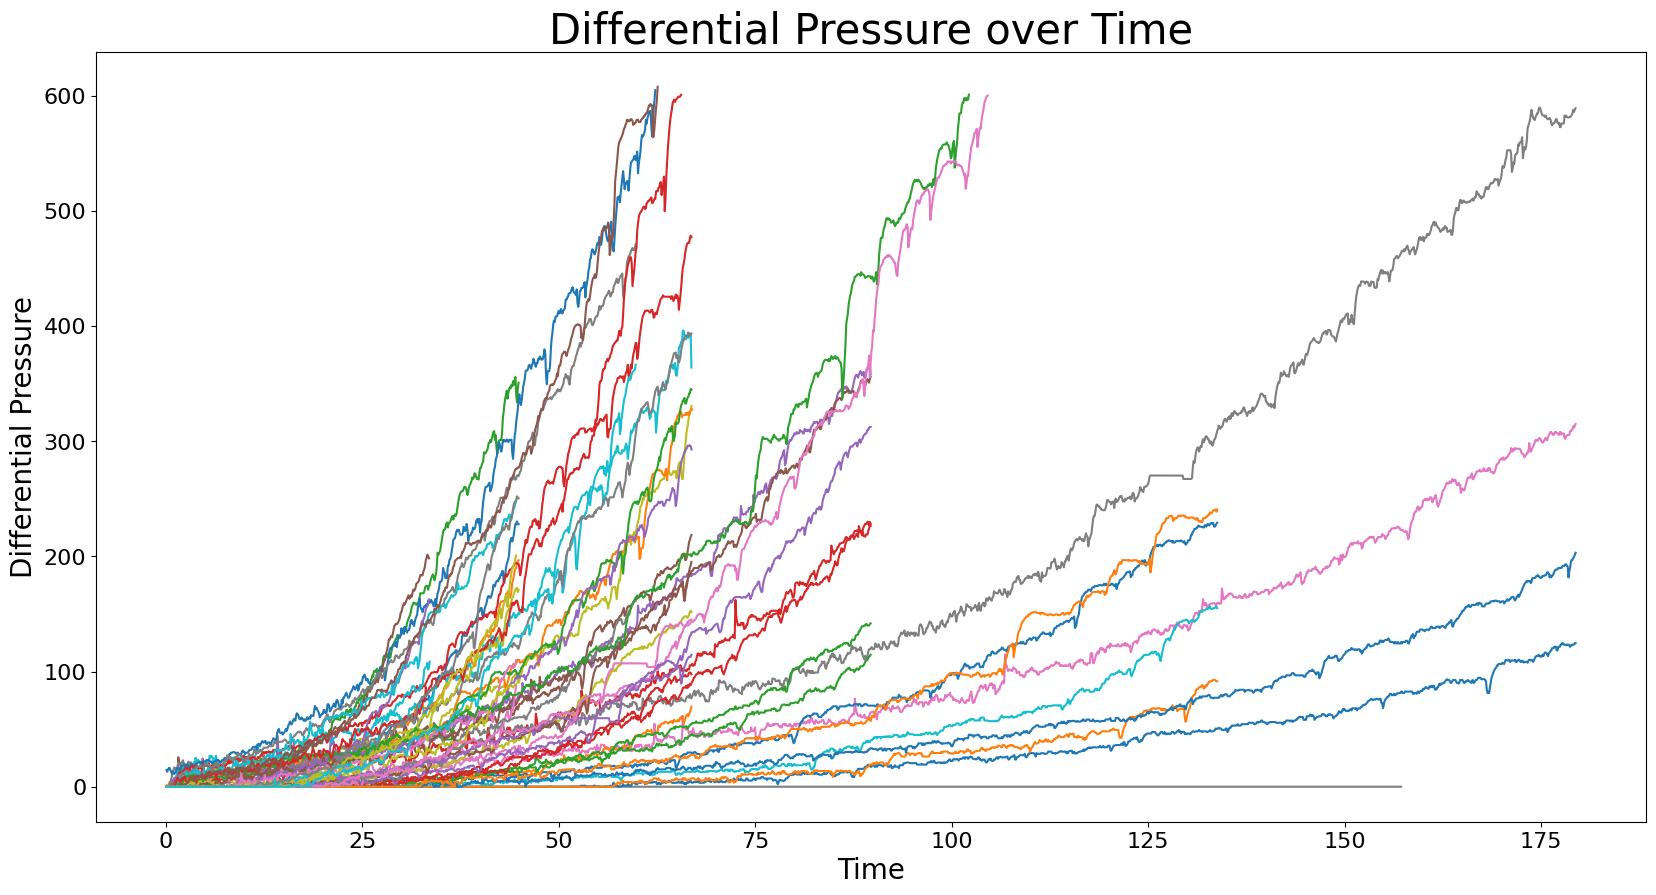

In [11]:
plt.figure(figsize = (20,10))
for data_no, df in train_df.groupby('Data_No'):
    plt.plot(df['Time'], df['Differential_pressure'])
    
plt.xlabel('Time', fontsize=20)
plt.ylabel('Differential Pressure', fontsize=20)
plt.tick_params(axis='both', labelsize=16)
plt.title('Differential Pressure over Time', fontsize=30)

# plt.savefig('diff_pressure', dpi=500, bbox_inches='tight')

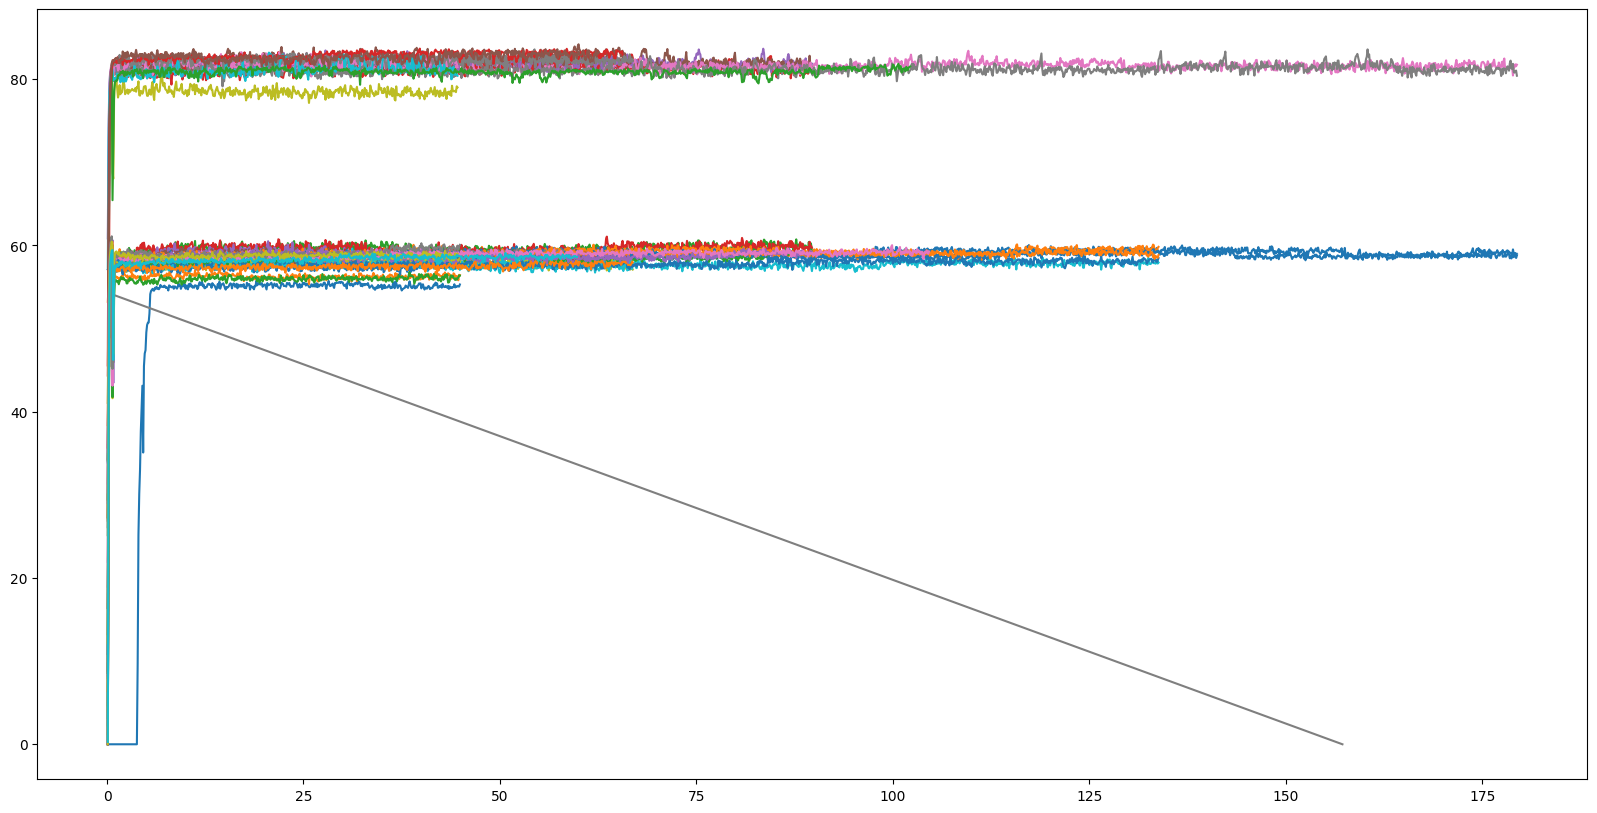

In [12]:
plt.figure(figsize = (20,10))
for data_no, df in train_df.groupby('Data_No'):
    plt.plot(df['Time'], df['Flow_rate'])

<Axes: ylabel='Dust_feed'>

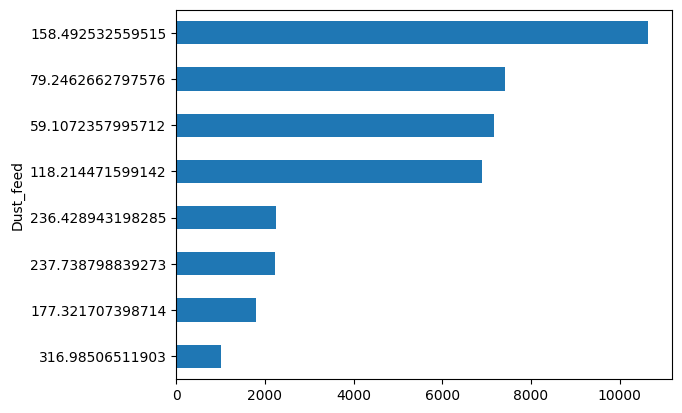

In [13]:
train_df['Dust_feed'].value_counts(ascending=True).plot(kind='barh')


In [14]:
# Create correlation matrix 
corr_matrix = test_df[["Differential_pressure","Flow_rate","Dust_feed","RUL"]].corr()

# Farbliche Abgrenzung hinzufügen
corr_matrix.style.background_gradient(cmap='coolwarm')

,Differential_pressure,Flow_rate,Dust_feed,RUL
Differential_pressure,1.000000,0.162771,-0.082623,-0.458465
Flow_rate,0.162771,1.000000,-0.411261,0.273620
Dust_feed,-0.082623,-0.411261,1.000000,-0.664177
RUL,-0.458465,0.273620,-0.664177,1.000000


In [15]:
# This function splits the input data into sequences and returns them as a generator
def x_reshape(df, columns, sequence_length):
    data = df[columns].values
    num_elements = data.shape[0]
    for start, stop in zip(range(0, 
                                 num_elements-sequence_length-10), # 10 = predicted time steps in future 
                           range(sequence_length,
                                 num_elements-10)):
        yield(data[start:stop, :])

# This function creates sequences of input data        
def get_x_slices(df, feature_columns):
    # Reshape the data to (samples, time steps, features)
    feature_list = [list(x_reshape(df[df['Data_No'] == i], feature_columns, 20)) #20 = sequences_length
                    for i in range(1, df['Data_No'].nunique() + 1) if len(df[df['Data_No']  == i]) > 20]
    feature_array = np.concatenate(list(feature_list), axis=0).astype(np.float64)

    length = len(feature_array) // 128
    return feature_array[:length*128]

# This function creates labels for the output data
def y_reshape(df, sequence_length, columns=['Differential_pressure']):
    data = df[columns].values
    num_elements = data.shape[0]
    return(data[sequence_length+10:num_elements, :])

# This function creates sequences of output data
def get_y_slices(df):
    label_list = [y_reshape(df[df['Data_No'] == i], 20) 
                  for i in range(1, df['Data_No'].nunique()+1)]
    label_array = np.concatenate(label_list).astype(np.float64)
    length = len(label_array) // 128
    return label_array[:length*128]

In [16]:
X_train = get_x_slices(train_df, ['Differential_pressure'])
X_test = get_x_slices(test_df,['Differential_pressure'])
y_train = get_y_slices(train_df)
y_test = get_y_slices(test_df)

In [17]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(37888, 20, 1)
(37888, 20, 1)
(37888, 1)
(37888, 1)


In [18]:
# Drop the last axis
X_train = np.squeeze(X_train, axis=2)
y_train = np.squeeze(y_train, axis=1)
X_test = np.squeeze(X_test, axis=2)
y_test = np.squeeze(y_test, axis=1)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(37888, 20)
(37888, 20)
(37888,)
(37888,)


In [19]:
# split train data in 90% train, 10% validation
train_size = int(len(X_train) * 0.9)
X_train, X_val = X_train[:train_size], X_train[train_size:]
y_train, y_val = y_train[:train_size], y_train[train_size:]

print("X Shape:", X_train.shape)
print("X Shape:", X_val.shape)

X Shape: (34099, 20)
X Shape: (3789, 20)


In [20]:
# Scale the data to a value between 0 and 1
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [21]:
#R2 score & MAE 
def evaluate(y_true, y_pred, label='test'):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print('{} set MAE:{}, R2:{}'.format(label, mae, r2))

In [22]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_lr_train = lin_reg.predict(X_train) #Prediction on train data
evaluate(y_train, y_lr_train, label='train')

y_lr_test = lin_reg.predict(X_test)  #Prediction on test data
evaluate(y_test, y_lr_test, label='test')


train set MAE:3.6707303996871756, R2:0.9965893402205237
test set MAE:4.654406140473208, R2:0.9961945249883999


In [23]:
sv = SVR(kernel='rbf')
sv.fit(X_train, y_train)

y_sv_train = sv.predict(X_train) #Prediction on train data
evaluate(y_train, y_sv_train, label='train')

y_sv_test = sv.predict(X_test)  #Prediction on test data
evaluate(y_test, y_sv_test, label='test')

train set MAE:4.085472516315362, R2:0.9929890451776926
test set MAE:4.994717745017306, R2:0.9946425135054054


In [24]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

y_rf_train = rf.predict(X_train) #Prediction on train data
evaluate(y_train,y_rf_train, label='train')

y_rf_test = rf.predict(X_test)  #Prediction on test data
evaluate(y_test, y_rf_test, label='test')

train set MAE:1.006211064995188, R2:0.999727866925918
test set MAE:4.5507595252516815, R2:0.9961998895079938


In [25]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 30, 50],
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt']
}
# Instantiate the grid search model
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_absolute_error', return_train_score=True)
grid_search.fit(X_val, y_val)

C:\Users\mevis\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
45 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\mevis\AppData\Roaming\Python\Python311\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\mevis\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 1145, in wrapper
    estimator._validate_params()
  File "C:\Users\mevis\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py", line 638, in _validate_params
    validat

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True], 'max_depth': [10, 30, 50],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [100, 200, 300]},
             return_train_score=True, scoring='neg_mean_absolute_error')

In [26]:
final_model = grid_search.best_estimator_
print(final_model)

RandomForestRegressor(max_depth=10, max_features='sqrt', n_estimators=300)


In [27]:
rf = final_model
rf.fit(X_train, y_train)

y_rf_train = rf.predict(X_train) #Prediction on train data
evaluate(y_train,y_rf_train, label='train')

y_rf_test = rf.predict(X_test)  #Prediction on test data
evaluate(y_test, y_rf_test, label='test')

train set MAE:2.576361767837451, R2:0.9985984040016042
test set MAE:4.662838650786452, R2:0.9959808762333794


In [28]:
knn = KNeighborsRegressor()
knn.fit(X_train, y_train)

y_knn_train = knn.predict(X_train) #Prediction on train data
evaluate(y_train,y_knn_train, label='train')

y_knn_test = knn.predict(X_test)  #Prediction on test data
evaluate(y_test, y_knn_test, label='test')

train set MAE:2.0590449561195343, R2:0.9988679809421104
test set MAE:4.998662841589157, R2:0.9949747176064853


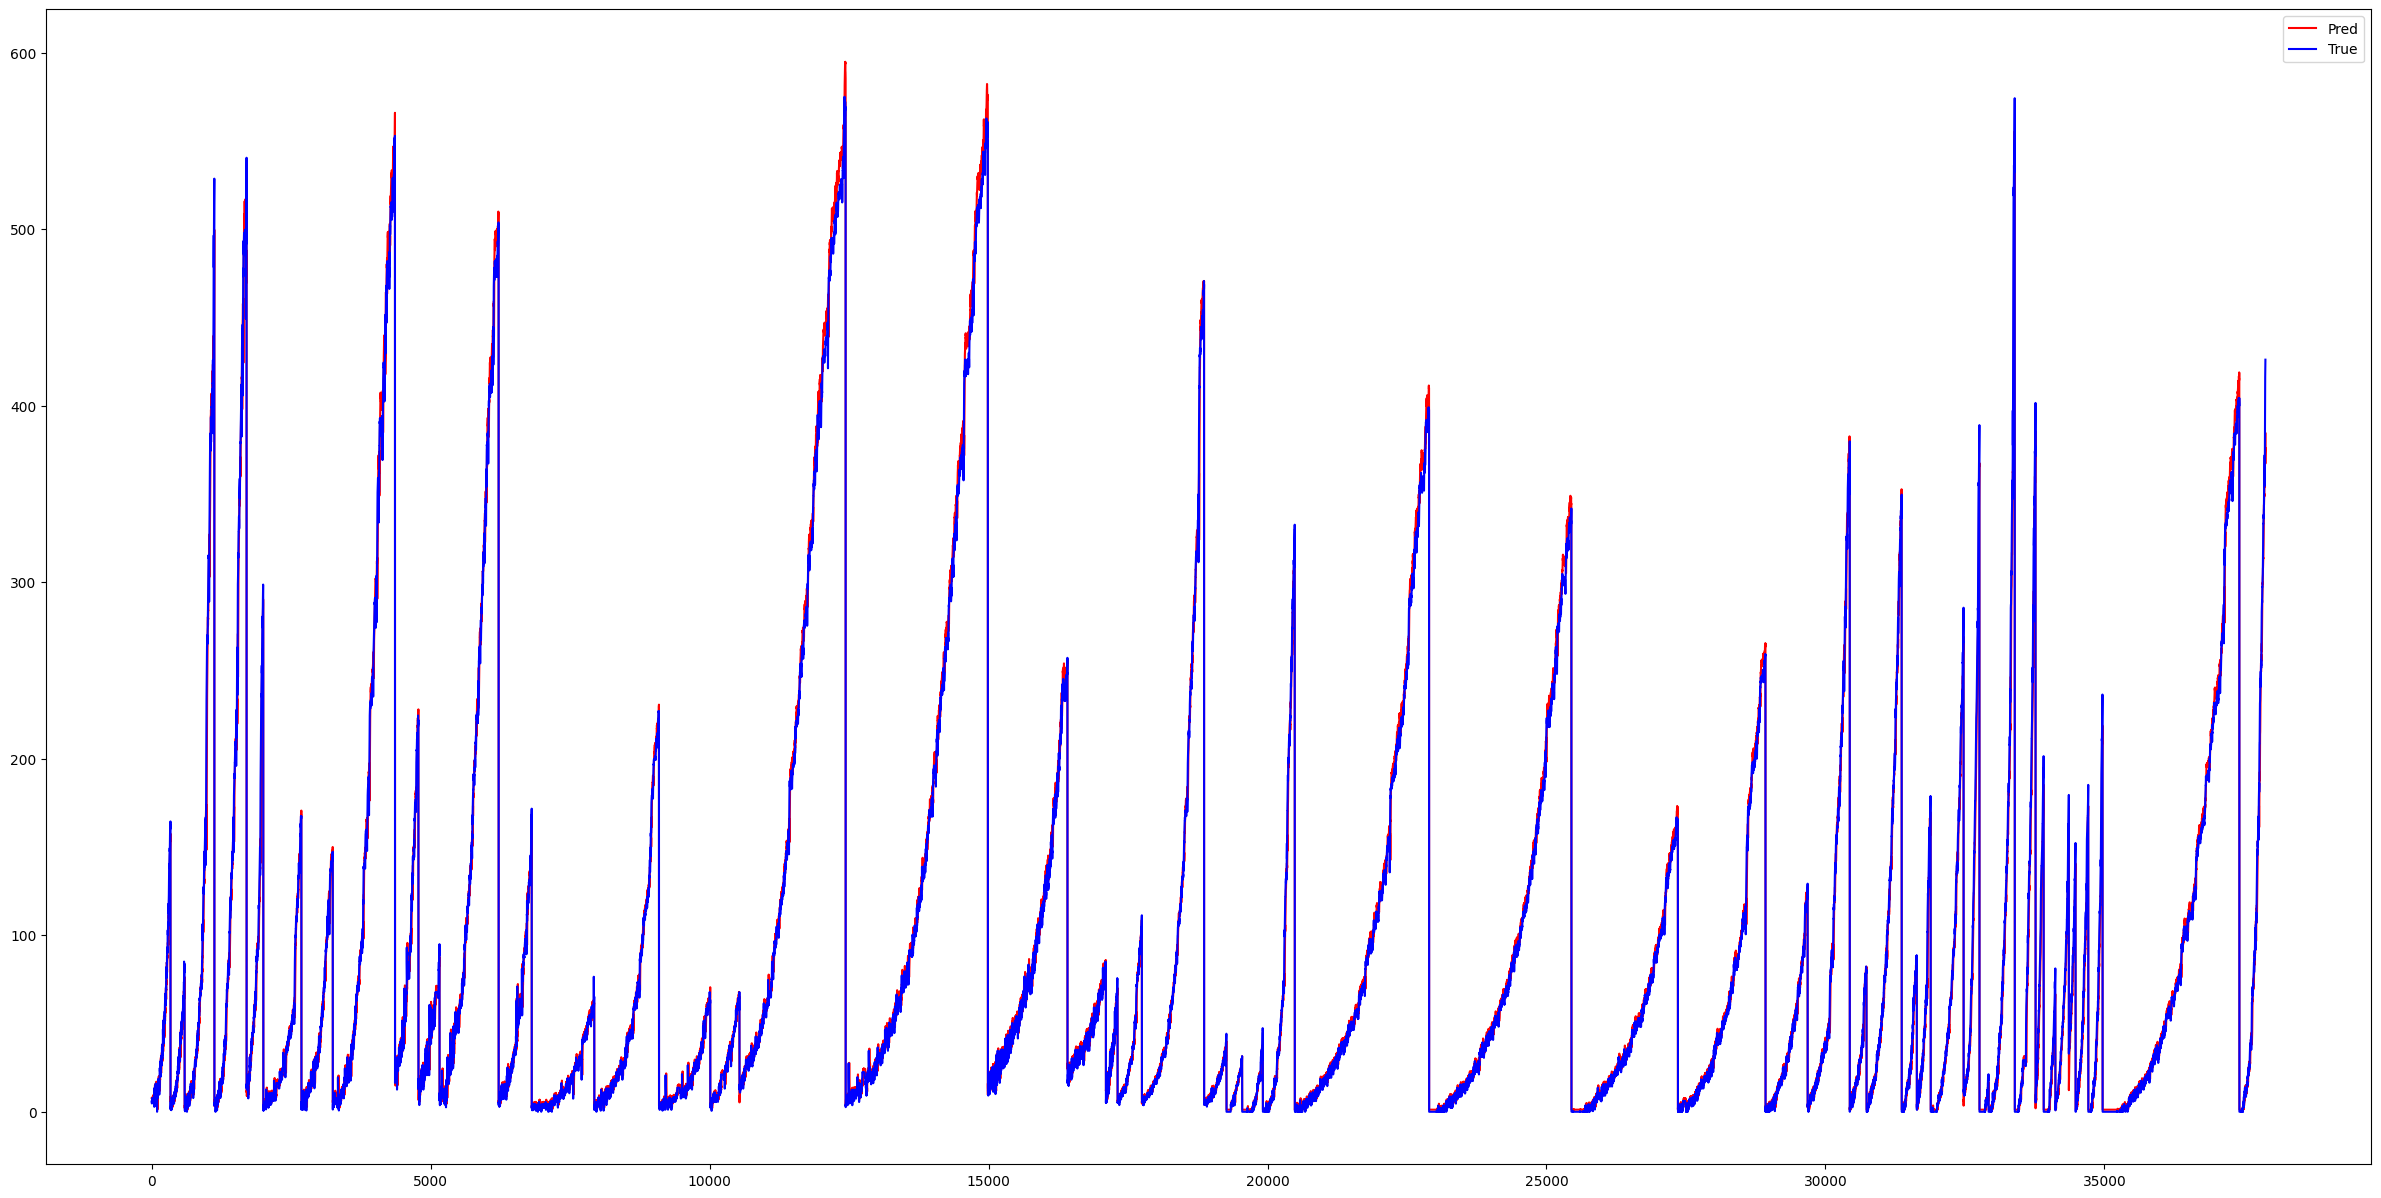

In [29]:
# Plot true and predicted values
plt.figure(figsize=(30,15))
plt.plot(y_lr_test, label = "Pred", color = "red")
plt.plot(y_test, label = "True", color = "blue")
plt.legend()
plt.show()


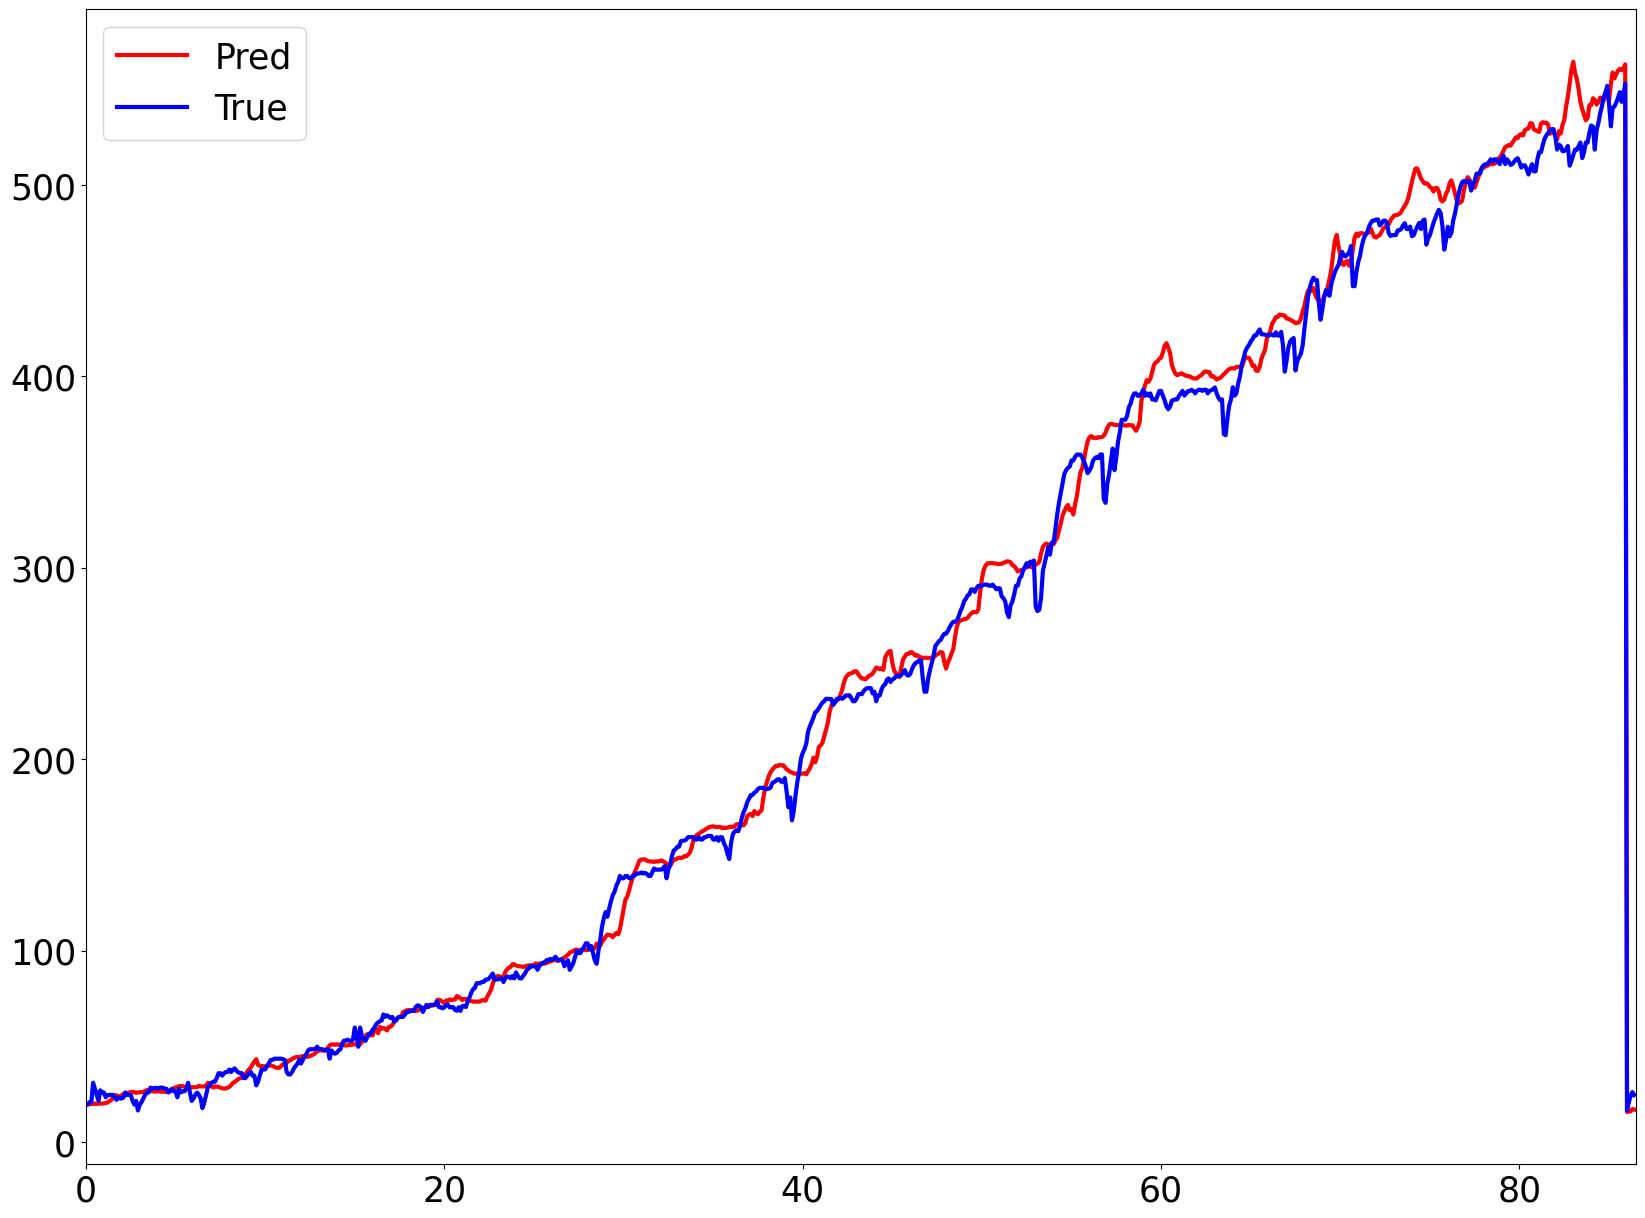

In [30]:

# plot only part:
y_lr_test_part = y_rf_test[3500:4365]
y_test_part = y_test[3500:4365]
# Plot true and predicted values
plt.figure(figsize=(20,15))
plt.plot(y_lr_test_part, label = "Pred", color = "red", linewidth=3)
plt.plot(y_test_part, label = "True", color = "blue", linewidth=3)
plt.legend(fontsize=25)
plt.tick_params(axis='both', labelsize=25)

#for seconds in x axis

# Get the current x-axis ticks
xticks = plt.xticks()[0]

# Modify the x-axis ticks by dividing by a factor of 10
new_xticks = [int(tick/10) for tick in xticks]

# Set the new x-axis ticks
plt.xticks(xticks, new_xticks)

# Set the limits of the x-axis
plt.xlim([0, len(y_test_part)])

plt.savefig('pred_diff_rf', dpi=500, bbox_inches='tight')

plt.show()


In [31]:
pred_failures = y_rf_test >=500
real_failures = y_test >=500

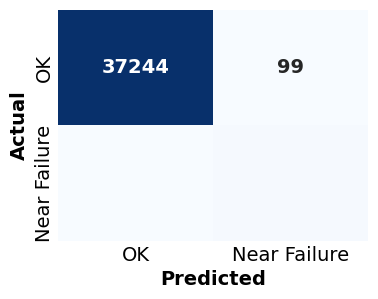

In [32]:
# Visualize the confusion matrix
fig, ax = plt.subplots(figsize=(4,3))
ax = sns.heatmap(confusion_matrix(real_failures,pred_failures), annot=True,
                 annot_kws={'size':14, 'weight':'bold'},
                 fmt='d', cbar=False, cmap='Blues')
ax.set_xticklabels(['OK', 'Near Failure'])
ax.set_yticklabels(['OK', 'Near Failure'], va='center')
plt.tick_params(axis='both', labelsize=14, length=0)
plt.ylabel('Actual', size=14, weight='bold')
plt.xlabel('Predicted', size=14, weight='bold')
plt.ylabel('Actual', size=14, weight='bold')
plt.xlabel('Predicted', size=14, weight='bold')

plt.savefig('conf_matrix_rf_530.png', dpi=500, bbox_inches='tight')

plt.show()

In [33]:
pred_failures = y_rf_test >=500
real_failures = y_test >=530

In [34]:
scaler = MinMaxScaler()
X_train = get_x_slices(train_df, ['Differential_pressure','Flow_rate'])
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = get_x_slices(test_df,['Differential_pressure','Flow_rate'])
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_train = get_y_slices(train_df)
y_test = get_y_slices(test_df)

In [35]:
# split train data in 90% train, 10% validation
train_size = int(len(X_train) * 0.9)
X_train, X_val = X_train[:train_size], X_train[train_size:]
y_train, y_val = y_train[:train_size], y_train[train_size:]

print("X Shape:", X_train.shape)
print("X Shape:", X_val.shape)


X Shape: (34099, 20, 2)
X Shape: (3789, 20, 2)


In [36]:
LSTM_model = Sequential()
LSTM_model.add(LSTM(input_shape=(X_train.shape[1], 
                            X_train.shape[2]), 
               units=16, 
               return_sequences=True))
LSTM_model.add(LSTM(units=32, 
               return_sequences=True))
LSTM_model.add(LSTM(units=16, 
               return_sequences=False))
LSTM_model.add(Dense(units=16))
LSTM_model.add(Dropout(0.2))

LSTM_model.add(Dense(units=1))

LSTM_model.compile(loss='mean_squared_error', 
              optimizer='adam',
              metrics=['mse','mae'])

In [37]:
LSTM_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 16)            1216      
                                                                 
 lstm_1 (LSTM)               (None, 20, 32)            6272      
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 10913 (42.63 KB)
Trainable params: 10913 (

In [38]:
es = EarlyStopping(monitor='val_mse',  
                   patience=3, 
                   verbose=True)

In [39]:
history = LSTM_model.fit(X_train,
                    y_train,
                    epochs=999, 
                    validation_data=(X_val, 
                                     y_val), 
                    callbacks=[es])

Epoch 1/999
1066/1066 [==============================] - 47s 32ms/step - loss: 9534.8584 - mse: 9534.8584 - mae: 56.1764 - val_loss: 6618.0757 - val_mse: 6618.0757 - val_mae: 32.0543
Epoch 2/999
1066/1066 [==============================] - 32s 30ms/step - loss: 1007.8930 - mse: 1007.8930 - mae: 13.4165 - val_loss: 799.2675 - val_mse: 799.2675 - val_mae: 13.9348
Epoch 3/999
1066/1066 [==============================] - 32s 30ms/step - loss: 401.4405 - mse: 401.4405 - mae: 10.8409 - val_loss: 251.3137 - val_mse: 251.3137 - val_mae: 9.7181
Epoch 4/999
1066/1066 [==============================] - 32s 30ms/step - loss: 361.1182 - mse: 361.1182 - mae: 10.6640 - val_loss: 413.2927 - val_mse: 413.2927 - val_mae: 13.0020
Epoch 5/999
1066/1066 [==============================] - 32s 30ms/step - loss: 358.1984 - mse: 358.1984 - mae: 10.4968 - val_loss: 277.8653 - val_mse: 277.8653 - val_mae: 10.3196
Epoch 6/999
1066/1066 [==============================] - 32s 30ms/step - loss: 343.4514 - mse: 343.4

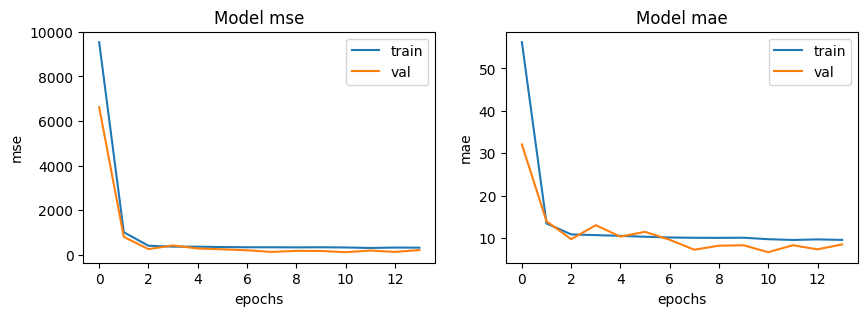

In [40]:
# Plot the loss and accuracy curves for training and validation 

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['mse', 'mae']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

plt.savefig('acc_curves.png', dpi=500, bbox_inches='tight')

In [41]:
pred_train = LSTM_model.predict(X_train)
evaluate(y_train, pred_train, label='train')

pred = LSTM_model.predict(X_test)
evaluate(y_test, pred, label='test')

1066/1066 [==============================] - 13s 10ms/step
train set MAE:5.539797678886644, R2:0.9920897487231295
1184/1184 [==============================] - 11s 9ms/step
test set MAE:6.2194153020086675, R2:0.9931455710045575
